<a href="https://colab.research.google.com/github/aamyren/TF-training/blob/main/Strided-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

TensorFlow version: 2.8.2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# adds some background data to training

# nx_train contains 30000 severely cropped and 30000 blank images to add to the training dataset
# ----------> maybe increase this later
nx_train = np.empty((60000,28,28,1))
# all 40000 of these images need labels
ny_train = np.empty(60000)

# function to shift the image so that it is cropped
def shifty(img):
    seed = random.randrange(10,18)
    new = np.roll(img, seed, axis = 0)
    return new
    
def shiftx(img):
    seed = random.randrange(10,18)
    new = np.roll(img, seed, axis = 1)
    #seed = random.randrange(84900000, 85000000)
    #new = np.roll(img, -15, axis=1)
    #new = np.roll(img, seed)
    return new

def shiftxy(img):
    seed = random.randrange(10,18)
    new = np.roll(img, seed, axis = (1,0))
    seed = random.randrange(10,18)
    new = np.roll(img, seed, axis = (0,1))
    return new

# changes the value of the first 60000 images to have a value "digit"
for i in range(60000):
    y_train[i] = 2

# cropped images correspond to class label 0
for i in range(30000):
    ny_train[i] = 0

# blank images correspond to class label 1
for i in range(30000, 60000):
    ny_train[i] = 1

# changes the first 30000 images in nx_train to be cropped, the rest are blank
for i in range(10000):
    nx_train[i] = shifty(x_train[i])
    #nx_train[i] = shiftx(x_train[i])

for i in range(10000,20000):
    nx_train[i] = shiftx(x_train[i])
    #nx_train[i] = shiftx(x_train[i])

for i in range(20000,30000):
    nx_train[i] = shiftxy(x_train[i])
    #nx_train[i] = shiftx(x_train[i])

# adjust how much data from the "digit" class we want to keep
mx_train = []
my_train = []
for i in range(30000):
    mx_train.append(x_train[i])
    my_train.append(y_train[i])

#print(y_train)
#print(ny_train)
#y_train.shape
#ny_train.shape

In [ ]:
# adds some background data to test data

# the 10000 test images should all be considered "digits"
for i in range(10000):
    y_test[i] = 1

x_test.shape
y_test.shape

# add 9000 non-digits to test
nx_test = np.zeros((9000,28,28,1))
# all 9000 of these images correspond to "background"
ny_test = np.zeros(9000)


# changes the value of the first 10000 images to have a value "digit"
for i in range(10000):
    y_test[i] = 2

# cropped images
for i in range(4500):
    ny_test[i] = 0
# blank
for i in range(4500, 9000):
    ny_test[i] = 1


# changes the first 4500 images in nx_test to be cropped, the rest are blank
for i in range(1500):
    #nx_test[i] = shift(x_test[i])
    nx_test[i] = shifty(x_test[i])

for i in range(1500, 3000):
    #nx_test[i] = shift(x_test[i])
    nx_test[i] = shiftx(x_test[i])

for i in range(1500, 4500):
    #nx_test[i] = shift(x_test[i])
    nx_test[i] = shiftxy(x_test[i])


#print(y_test)
#print(ny_test)
#y_test.shape
#ny_test.shape



In [ ]:
nx_train.shape

(60000, 28, 28, 1)

In [ ]:
## add the new data into x_train and y_train
# nx_train = np.resize(nx_train, (32000, 28, 28,1))

mx_train = np.concatenate((mx_train, nx_train))
my_train = np.concatenate((my_train, ny_train))

#x_train.shape
#x_test.shape
#y_test.shape

In [ ]:
x_test = np.concatenate((x_test, nx_test))
y_test = np.concatenate((y_test, ny_test))


In [ ]:
x_test.shape

(19000, 28, 28, 1)

In [ ]:
# checking how the cropped images look
'''
nx_train = np.resize(nx_train, (30000, 28, 28))

plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(nx_train[i], cmap=plt.cm.binary)
    plt.xlabel(ny_train[i])
plt.show()'''

'\nnx_train = np.resize(nx_train, (30000, 28, 28))\n\nplt.figure(figsize=(10,10))\nfor i in range(100):\n    plt.subplot(10,10,i+1)\n    plt.xticks([])\n    plt.yticks([])\n    plt.grid(False)\n    plt.imshow(nx_train[i], cmap=plt.cm.binary)\n    plt.xlabel(ny_train[i])\nplt.show()'

In [ ]:
'''nx_train = np.resize(nx_train, (60000, 28, 28))
plt.figure()
plt.imshow(nx_train[4738], cmap = plt.cm.binary)'''

'nx_train = np.resize(nx_train, (60000, 28, 28))\nplt.figure()\nplt.imshow(nx_train[4738], cmap = plt.cm.binary)'

In [ ]:
#nx_train = np.resize(nx_train, (120000, 28, 28, 1))

In [ ]:
# set up network for the filter, which detects background/digit

train_ds = tf.data.Dataset.from_tensor_slices(
    (mx_train, my_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [ ]:
class Filter(Model):
  def __init__(self):
    super(Filter, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(3)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
filter = Filter()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = filter(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, filter.trainable_variables)
  optimizer.apply_gradients(zip(gradients, filter.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = filter(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.006081289146095514, Accuracy: 99.92444610595703, Test Loss: 0.0008889682358130813, Test Accuracy: 99.98420715332031
Epoch 2, Loss: 0.0002874603378586471, Accuracy: 99.99444580078125, Test Loss: 0.001814084011130035, Test Accuracy: 99.92631530761719
Epoch 3, Loss: 0.00031803984893485904, Accuracy: 99.99221801757812, Test Loss: 0.0021021722350269556, Test Accuracy: 99.98947143554688
Epoch 4, Loss: 3.3331489248666912e-06, Accuracy: 100.0, Test Loss: 0.0012924371985718608, Test Accuracy: 99.99473571777344
Epoch 5, Loss: 5.399376732384553e-07, Accuracy: 100.0, Test Loss: 0.0014458366204053164, Test Accuracy: 99.99473571777344


In [ ]:
# checking predictions

#probability_model = tf.keras.Sequential([filter, 
#                                         tf.keras.layers.Softmax()])

In [ ]:
#x_test = np.resize(x_test, (15000, 28, 28, 1))
#filter_predictions = probability_model.predict(x_test)

In [ ]:
#np.argmax(filter_predictions[0])

In [ ]:
#x_test = np.resize(x_test, (15000, 28, 28))

#plt.figure()
#plt.imshow(x_test[43], cmap = plt.cm.binary)

#np.argmax(filter_predictions[43])

# the network to identify ----digit or background---- has been completed and trained at this point 

In [ ]:
filter.save_weights('checkpoint_1')

In [ ]:
# ----Classifier---- neural network begins here

In [ ]:
# import mnist data
mnist = tf.keras.datasets.mnist

(cx_train, cy_train), (cx_test, cy_test) = mnist.load_data()
cx_train, cx_test = cx_train / 255.0, cx_test / 255.0

# Add a channels dimension
cx_train = cx_train[..., tf.newaxis].astype("float32")
cx_test = cx_test[..., tf.newaxis].astype("float32")

In [ ]:
# set up classifier network to identify the digit, same as problem 1)pt2)
train_ds = tf.data.Dataset.from_tensor_slices(
    (cx_train, cy_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((cx_test, cy_test)).batch(32)

In [ ]:
# load weights from the filter network into the classifier network
# filter.load_weights('checkpoint_1')

In [ ]:
class Classifier(Model):
  def __init__(self):
    super(Classifier, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
classifier = Classifier()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = classifier(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, classifier.trainable_variables)
  optimizer.apply_gradients(zip(gradients, classifier.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = classifier(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.13785535097122192, Accuracy: 95.82666778564453, Test Loss: 0.0667387843132019, Test Accuracy: 97.91999816894531
Epoch 2, Loss: 0.04667611047625542, Accuracy: 98.51333618164062, Test Loss: 0.0518634095788002, Test Accuracy: 98.2699966430664
Epoch 3, Loss: 0.024410484358668327, Accuracy: 99.23833465576172, Test Loss: 0.06407970935106277, Test Accuracy: 98.07999420166016
Epoch 4, Loss: 0.015367086045444012, Accuracy: 99.50333404541016, Test Loss: 0.055316176265478134, Test Accuracy: 98.43000030517578
Epoch 5, Loss: 0.010461768135428429, Accuracy: 99.63166809082031, Test Loss: 0.05413881689310074, Test Accuracy: 98.61000061035156


In [ ]:
classifier.save_weights('checkpoint_2')

In [ ]:
# ----Classifier network---- training completed here

In [ ]:
# begin setting up evaluation data for striding 

import os
import random
import numpy as np
import tensorflow as tf
import scipy.io as spio
from tqdm import trange
from matplotlib import cm
from keras.utils import np_utils
from matplotlib import pyplot
from google.colab.patches import cv2_imshow


In [ ]:
#Functions to convert .mat file to image arrays (Source:Github)
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)


def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        


def _todict(matobj):
    #A recursive function which constructs from matobjects nested dictionaries
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def visualization(vector, vector_name):
    y = np.reshape(vector, (40, 40))
    plt.imshow(y, cmap=cm.Greys_r)
    plt.suptitle(vector_name)
    plt.axis('off')
    plt.pause(0.0001)
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Define number of classes
nb_classes = 10

#Load .mat data
dataset = loadmat("/content/drive/My Drive/training_and_validation_batches/1.mat")

#Extract image array and the corresponding label   
y_val = dataset['affNISTdata']['label_int']
X_val = dataset['affNISTdata']['image'].transpose()

#Reshape and preprocess label
X_val = X_val.reshape(60000, 40, 40)
X_val = X_val.astype("float64")
y_val = np_utils.to_categorical(y_val, nb_classes)

#Save Files in .npy format
np.save("/content/drive/My Drive/Colab Notebooks/Completed/affNIST_X_val", X_val)
np.save("/content/drive/My Drive/Colab Notebooks/Completed/affNIST_y_val", y_val)


In [ ]:
# Checking how the imported data looks

#plt.figure(figsize=(10,10))
#for i in range(100):
#    plt.subplot(10,10,i+1)
#    plt.xticks([])
#    plt.yticks([])
#    plt.grid(False)
#    plt.imshow(X_val[i], cmap=plt.cm.binary)
#    plt.xlabel(y_val[i])
#plt.show()

In [ ]:
X_val = np.resize(X_val, (60000, 40, 40))

In [ ]:
# small strider returns array of all strided images of a given index of X_val
def s_strider(j):
    s_list = []
    coord = []
    strides = np.empty((144, 28, 28)) # first index is number of total strides
    for x in range(0,12,1): # 3rd index is step size of strides
        for y in range(0,12,1):
            s = X_val[j][x:x+28,y:y+28]
            #plt.figure()
            #plt.imshow(s, cmap = plt.cm.binary)
            s_list.append(s)
            coord.append([x,y])
    for i in range(144):
        if strides[i].shape == s_list[i].shape:
            strides[i] = s_list[i]
        else:
            break
    strides = np.resize(strides, (144, 28, 28, 1))
    #return s_list
    return strides

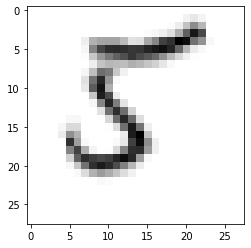

In [ ]:
# set up predictions from the filter network
f_probability_model = tf.keras.Sequential([filter, 
                                         tf.keras.layers.Softmax()])
# can change the number for strider() based on index in X_val to check
s = s_strider(1600) 
stride_filter_predictions = f_probability_model.predict(s)    
#print(np.argmax(stride_filter_predictions))      

s_predict = []

# manually display output of striding
s = np.resize(s, (144, 28, 28))

import statistics
b = 0
results = []
for i in range(0,144):
    s_predict.append(np.max(stride_filter_predictions))
    if np.argmax(stride_filter_predictions[i]) == 2:
        results.append(i)
        #b = i
        #plt.figure()
        #plt.imshow(s[b], cmap = plt.cm.binary)
        #print(b)    

#if len(results) > 20:
#    b = results[1]
#else:
#    b = results[-2]
b = int(statistics.median(results))
plt.figure()
plt.imshow(s[b], cmap = plt.cm.binary)
#print(b)    


In [ ]:
# identify 1-10 the cropped digits
# set up predictions from the classifier network
c_probability_model = tf.keras.Sequential([classifier, 
                                         tf.keras.layers.Softmax()]) 
s = np.resize(s, (144, 28, 28, 1))
stride_classifier_predictions = c_probability_model.predict(s)      
print("The digit above is : ", np.argmax(stride_classifier_predictions))
#print(stride_classifier_predictions[b])

The digit above is :  5


In [ ]:
# evaluations of 256x256 images begin here --------

In [ ]:
X_val = np.resize(X_val, (60000, 40, 40, 1))

# make 256x256 image
# i am making them 1 at a timebecause session crashes from too much RAM useage otherwise
large_x = np.zeros((1,256,256,1))

# place an index of X_val randomly somewhere in 256x256 image
x = random.randrange(216)
# print (x, y)
y = random.randrange(216)
large_x[0][x:x+X_val.shape[1], y:y+X_val.shape[2]] = X_val[888] # can change index of X_val

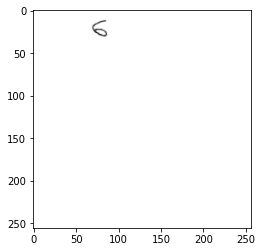

In [ ]:
# display 256x256 sized figure
large_x = np.resize(large_x, (1, 256, 256))
plt.figure()
plt.imshow(large_x[0], cmap = plt.cm.binary)


In [ ]:
# large strider returns array of all strided images of a given index of X_val
def l_strider(j):
    s_list = []
    coord = []
    strides = np.empty((3249, 28, 28)) # first index is number of total strides
    for x in range(0,228,4): # 3rd index is step size of strides
        for y in range(0,228,4):
            s = large_x[0][x:x+28,y:y+28]
            #plt.figure()
            #plt.imshow(s, cmap = plt.cm.binary)
            s_list.append(s)
            coord.append([x,y])
    for i in range(3249):
        if strides[i].shape == s_list[i].shape:
            strides[i] = s_list[i]
        else:
            break
    strides = np.resize(strides, (3249, 28, 28, 1))
    #return s_list

    return strides

In [ ]:
import statistics

130


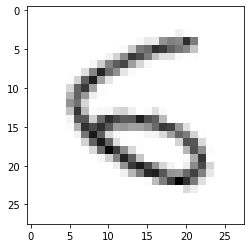

In [ ]:
# set up predictions from the filter network
f_probability_model = tf.keras.Sequential([filter, 
                                         tf.keras.layers.Softmax()])
# can change the number for strider() based on index in X_val to check
l_s = l_strider(12)
l_stride_filter_predictions = f_probability_model.predict(l_s)          

# manually display output of striding
l_s = np.resize(l_s, (3249, 28, 28))

# find which strided boxes have predictions correspond to class 2 (digit only)
b2 = 0
results2 = []
for i in range(0,3249):
    if np.argmax(l_stride_filter_predictions[i]) == 2:
        results2.append(i)
        #b = i
        #plt.figure()
        #plt.imshow(l_s[b2], cmap = plt.cm.binary)
        #print(b2)    

# i take the median of predictions in case there are multiple boxes corresponding to digit- generally the image will be centered this way
b2 = int(statistics.median(results2))
# manual check 
l_s = np.resize(l_s, (3249, 28, 28))
plt.figure()
plt.imshow(l_s[b2], cmap = plt.cm.binary)
print(b2)

In [ ]:
# identify 1-10 the cropped digits

# set up predictions from the classifier network
#c2_probability_model = tf.keras.Sequential([classifier, 
#                                         tf.keras.layers.Softmax()]) 
l_s = np.resize(l_s, (3249, 28, 28, 1))
stride2_classifier_predictions = c_probability_model.predict(l_s)      
print("The digit above is : ", np.argmax(stride2_classifier_predictions[b2]))


The digit above is :  6


In [ ]:
# list with same structure as the strider loops to help find coordinates based on the output index
a = []
for x in range(0,228,4):
    for y in range(0,228,4):
        s = X_val[2][x:x+28,y:y+28]
        a.append((x,y))

# len(a)
# a[b2]


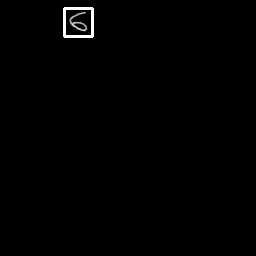

In [ ]:
# draw box around figure
from google.colab.patches import cv2_imshow
# initiates blank array every time so that rectangles aren't drawn directly on the data and so that drawings can be reset each time
drawing = np.empty((1, 256, 256))
# draw bounding rectangle based on coordinates found in list a
drawing[0] = large_x[0] 
image = drawing[0]
start_point = (a[b2][1],a[b2][0])
end_point = (a[b2][1]+28, a[b2][0]+28)
color = (255, 0, 0)
thickness = 2
image = cv2.rectangle(image, start_point, end_point, color, thickness)
cv2_imshow(image) 
